# Digit Recognizer
This is a simple image classification challenge using the famous [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database). Lets see if we can train a classifier that can accurately distinguish handwritten digits.

<img src="images/MnistExamples.png">

### Goal
The goal in this competition is to take an image of a handwritten single digit, and determine what that digit is.
For every in the test set, you should predict the correct label.

### Metric
This competition is evaluated on the categorization accuracy of your predictions (the percentage of images you get correct).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")

Loading **taining** and **testing** data

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

Seperating features (images : X) and labels (correct digit labels: y)

In [3]:
y_train = train["label"]
X_train = train.drop(labels=["label"], axis=1); del train

## 1. Data exploration

Checking the count of each label

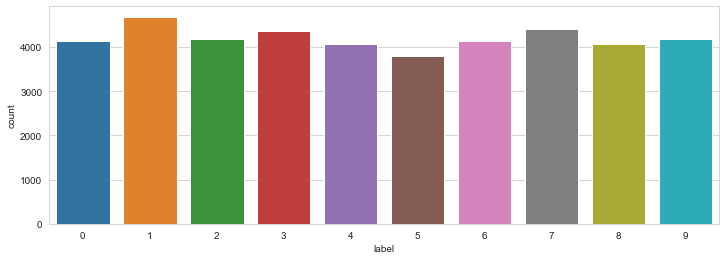

In [4]:
plt.figure(figsize=(12, 4))
sns.countplot(y_train)

In [5]:
y_train.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

We can see that there are more or less similar number of images for each digit. So its less likely that our classifier will get biased due to representation error (eg: suppose the digit 5 being predicted most of the time because there are a larger number of images of 5s in our dataset compared to other numbers).

## 2. Data preparation

### 2.1 Reshaping images
The images are currently flattened: 28x28 grayscale images flattened = 784 pixels. This is so that it is easier to pass into traditional Machine Learning classifiers such as SVCs or Random Forest classifiers. However, for image data Convolutional Neural Networks (CNNs) are currently the best choice. Therefore, we will reshape the images into their original dimensions: 28x28x1 (1 channel).

In [6]:
X_train = X_train.values.reshape(-1, 28, 28, 1) # Training images
test = test.values.reshape(-1, 28, 28, 1)       # Test set

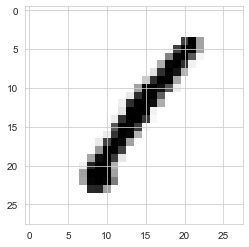

In [14]:
plt.imshow(X_train[0][:, :, 0], cmap='binary')